In [2]:
import os,cv2,random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

In [2]:
#Download data from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
#Extract both files on currect directory where the code is running

TRAIN_DIR = 'train/'
TEST_DIR = 'test/'

ROWS = 256
COLS = 256
ROWS2 = 64
COLS2 = 64
CHANNELS = 3

train_images = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR)]
train_dogs = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images = [TEST_DIR + i for i in os.listdir(TEST_DIR)]

#slice datasets
#train_images = train_dogs[:10000] + train_cats[:10000]
#random.shuffle(train_images)
#test_images = test_images[:1000]


In [3]:
def read_image(file_path):
    img = cv2.imread(file_path,cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2,(ROWS2,COLS2),interpolation = cv2.INTER_CUBIC)

def read_image2(file_path):
    img = cv2.imread(file_path,cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2,(ROWS,COLS),interpolation = cv2.INTER_CUBIC)


In [4]:
def prep_data(images):
    count = len(images)
    data = np.ndarray((count,CHANNELS,ROWS2,COLS2),dtype = np.uint8)
    
    for i ,image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i % 1000 == 0:print("Processed {} of {}".format(i,count))
        
    return data

def prep_data2(images):
    count = len(images)
    data = np.ndarray((count,CHANNELS,ROWS,COLS),dtype = np.uint8)
    
    for i ,image_file in enumerate(images):
        image = read_image2(image_file)
        data[i] = image.T
        if i % 500 == 0:print("Processed {} of {}".format(i,count))
        
    return data

train = prep_data(train_images)
test = prep_data(test_images)
test2 = prep_data2(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape:{}".format(test.shape))

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000


KeyboardInterrupt: 

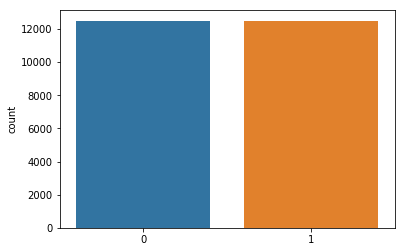

In [5]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)
        
sns.countplot(labels)

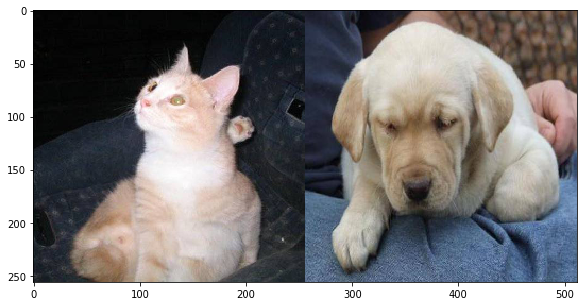

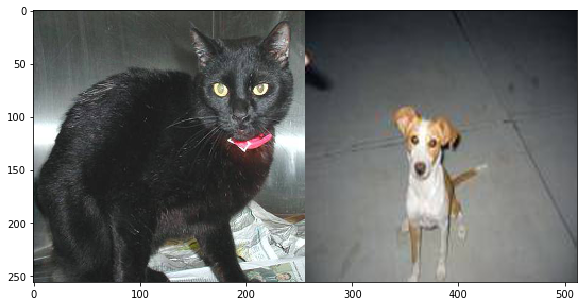

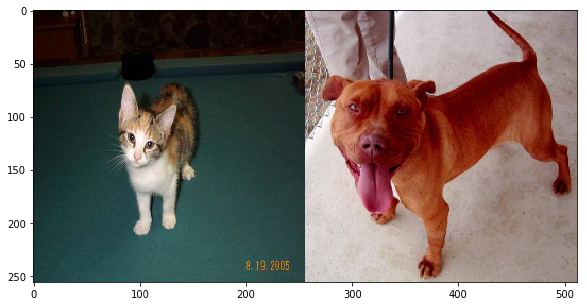

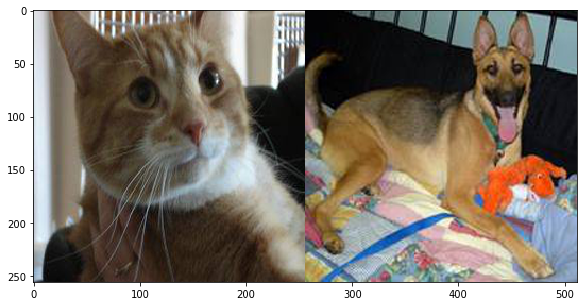

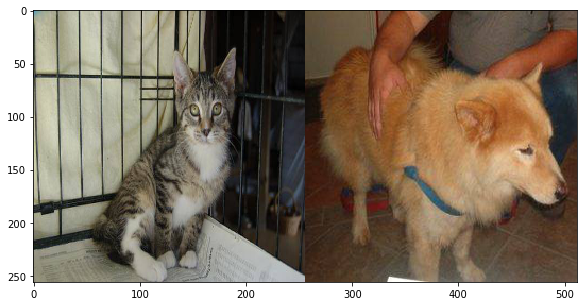

In [6]:
def show_cats_and_dogs(idx):
    cat = read_image2(train_cats[idx])
    dog = read_image2(train_dogs[idx])
    pair = np.concatenate((cat,dog),axis = 1)
    plt.figure(figsize = (10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

In [7]:
from keras.models import Sequential
from keras.layers import Input,Dropout,Flatten,Conv2D,MaxPooling2D,Dense,Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint,Callback,EarlyStopping
from keras.utils import np_utils
optimizer = RMSprop(lr = 1e-4)
objective = 'binary_crossentropy'

def catdog():
    
    model = Sequential()
    #Input layer
    model.add(Conv2D(32,3,padding = 'same',input_shape = train.shape[1:],activation = 'relu'))
    model.add(Conv2D(32,3,padding = 'same',activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2),data_format = 'channels_first'))
    #First layer
    model.add(Conv2D(64,3,padding = 'same',activation = 'relu'))
    model.add(Conv2D(32,3,padding = 'same',activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2),data_format = 'channels_first'))
    
    #Second layer
    model.add(Conv2D(128,3,padding = 'same',activation = 'relu'))
    model.add(Conv2D(32,3,padding = 'same',activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2),data_format = 'channels_first'))
    
    #Third layer
    model.add(Conv2D(256,3,padding = 'same',activation = 'relu'))
    model.add(Conv2D(256,3,padding = 'same',activation = 'relu'))
    model.add(Conv2D(256,3,padding = 'same',activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2),data_format = 'channels_first'))
    
    model.add(Flatten())
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    print("Compiling model...")
    model.compile(loss = objective,optimizer = optimizer,metrics = ['accuracy'])
    return model
print("Creating Model:")
model = catdog()

/home/paperspace/anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Creating Model:
Compiling model...


In [10]:
epochs = 10
batch_size = 16

class LossHistory(Callback):
    def on_train_begin(self,logs ={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self , batch,logs = {}):
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))
early_stopping = EarlyStopping(monitor = 'val_loss',patience = 3,verbose = 1,mode = 'auto')



In [11]:
def run_catdog():
    history = LossHistory()
    print("running model..")
    model.fit(train,labels,batch_size=batch_size,epochs = epochs,
             validation_split=0.25,verbose = 2,shuffle = True,callbacks = [history,early_stopping])
    
    print("making prediction on test set..")
    prediction = model.predict(test,verbose = 0)
    return prediction,history

predictions , history = run_catdog()
loss = history.losses
val_loss = history.val_losses

running model..
Train on 18750 samples, validate on 6250 samples
Epoch 1/10
 - 12s - loss: 0.5743 - acc: 0.7097 - val_loss: 0.6036 - val_acc: 0.7045
Epoch 2/10
 - 12s - loss: 0.5700 - acc: 0.7189 - val_loss: 0.5865 - val_acc: 0.6896
Epoch 3/10
 - 12s - loss: 0.5670 - acc: 0.7261 - val_loss: 0.6173 - val_acc: 0.6898
Epoch 4/10
 - 12s - loss: 0.5664 - acc: 0.7239 - val_loss: 0.5865 - val_acc: 0.6947
Epoch 5/10
 - 12s - loss: 0.5627 - acc: 0.7334 - val_loss: 0.6407 - val_acc: 0.6634
Epoch 6/10
 - 12s - loss: 0.5476 - acc: 0.7380 - val_loss: 0.6876 - val_acc: 0.6931
Epoch 7/10
 - 12s - loss: 0.5565 - acc: 0.7317 - val_loss: 0.6563 - val_acc: 0.7054
Epoch 00007: early stopping
making prediction on test set..


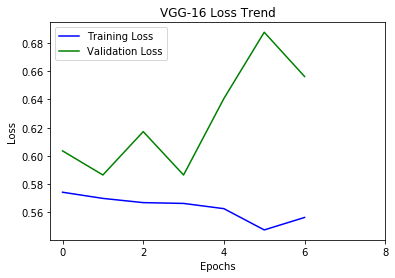

In [12]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("VGG-16 Loss Trend")
plt.plot(loss,'blue',label = 'Training Loss')
plt.plot(val_loss,'green',label = 'Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()


In [ ]:
for i in range(0,10):
    if predictions[i,0] >= 0.5:
        print("{:.2%} confident this is a Dog".format(predictions[i][0]))
    else:
        print("{:.2%} confident this is a Cat".format(1-predictions[i][0]))
            
    plt.imshow(test2[i].T)
    plt.show()